In [12]:
# Check data directory structure
import os

# Define data paths
data_dir = './data'

print("🔍 Checking data structure...")

if os.path.exists(data_dir):
    print("✅ Data directory found!")
    
    # Check main folders
    patients_dir = os.path.join(data_dir, 'patients')
    controls_dir = os.path.join(data_dir, 'controls')
    
    print(f"📁 Patients folder exists: {os.path.exists(patients_dir)}")
    print(f"📁 Controls folder exists: {os.path.exists(controls_dir)}")
    
    # Check subfolders
    if os.path.exists(patients_dir):
        patients_imgs = os.path.join(patients_dir, 'imgs')
        patients_labels = os.path.join(patients_dir, 'labels')
        print(f"   📷 Patient images: {os.path.exists(patients_imgs)}")
        print(f"   🏷️  Patient labels: {os.path.exists(patients_labels)}")
        
        if os.path.exists(patients_imgs):
            img_count = len([f for f in os.listdir(patients_imgs) if f.endswith('.png')])
            print(f"      Found {img_count} patient images")
            
        if os.path.exists(patients_labels):
            label_count = len([f for f in os.listdir(patients_labels) if f.endswith('.png')])
            print(f"      Found {label_count} patient labels")
    
    if os.path.exists(controls_dir):
        controls_imgs = os.path.join(controls_dir, 'imgs')
        print(f"   📷 Control images: {os.path.exists(controls_imgs)}")
        
        if os.path.exists(controls_imgs):
            control_count = len([f for f in os.listdir(controls_imgs) if f.endswith('.png')])
            print(f"      Found {control_count} control images")

else:
    print("❌ Data directory not found!")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Available directories: {[d for d in os.listdir('.') if os.path.isdir(d)]}")

🔍 Checking data structure...
✅ Data directory found!
📁 Patients folder exists: True
📁 Controls folder exists: True
   📷 Patient images: True
   🏷️  Patient labels: True
      Found 182 patient images
      Found 182 patient labels
   📷 Control images: True
      Found 426 control images


In [13]:
# Fixed dataset analysis with proper file matching
def analyze_dataset_fixed():
    """Get comprehensive dataset statistics with proper file matching"""
    
    # Paths
    patients_imgs = os.path.join(data_dir, 'patients', 'imgs')
    patients_labels = os.path.join(data_dir, 'patients', 'labels')
    controls_imgs = os.path.join(data_dir, 'controls', 'imgs')
    
    # Count files
    patient_files = [f for f in os.listdir(patients_imgs) if f.endswith('.png')] if os.path.exists(patients_imgs) else []
    label_files = [f for f in os.listdir(patients_labels) if f.endswith('.png')] if os.path.exists(patients_labels) else []
    control_files = [f for f in os.listdir(controls_imgs) if f.endswith('.png')] if os.path.exists(controls_imgs) else []
    
    print("📊 DATASET STATISTICS")
    print("=" * 50)
    print(f"Patient images with tumors: {len(patient_files)}")
    print(f"Ground truth labels:        {len(label_files)}")
    print(f"Healthy control images:     {len(control_files)}")
    print(f"Total images:               {len(patient_files) + len(control_files)}")
    print()
    
    # Show file naming patterns
    print("File Naming Patterns:")
    if patient_files:
        print(f"  Patient files: {patient_files[0]}, {patient_files[1]}, ...")
    if label_files:
        print(f"  Label files:   {label_files[0]}, {label_files[1]}, ...")
    print()
    
    # Extract numbers for proper matching
    # patient_XXX.png -> XXX
    patient_numbers = set()
    for f in patient_files:
        if f.startswith('patient_') and f.endswith('.png'):
            num = f.replace('patient_', '').replace('.png', '')
            patient_numbers.add(num)
    
    # segmentation_XXX.png -> XXX  
    label_numbers = set()
    for f in label_files:
        if f.startswith('segmentation_') and f.endswith('.png'):
            num = f.replace('segmentation_', '').replace('.png', '')
            label_numbers.add(num)
    
    # Find matches
    matched_numbers = patient_numbers.intersection(label_numbers)
    missing_labels = patient_numbers - label_numbers
    extra_labels = label_numbers - patient_numbers
    
    print(f"Number-based Label Coverage:")
    print(f"  Patients with matching labels: {len(matched_numbers)}/{len(patient_numbers)} ({len(matched_numbers)/len(patient_numbers)*100:.1f}%)")
    print(f"  Missing labels: {len(missing_labels)}")
    print(f"  Extra labels (no patient): {len(extra_labels)}")
    
    if missing_labels:
        missing_list = sorted(list(missing_labels))[:5]
        print(f"  Examples of missing: {missing_list}")
    
    if extra_labels:
        extra_list = sorted(list(extra_labels))[:5]
        print(f"  Examples of extra: {extra_list}")
    
    return patient_files, label_files, control_files, matched_numbers

patient_files, label_files, control_files, matched_numbers = analyze_dataset_fixed()

📊 DATASET STATISTICS
Patient images with tumors: 182
Ground truth labels:        182
Healthy control images:     426
Total images:               608

File Naming Patterns:
  Patient files: patient_000.png, patient_001.png, ...
  Label files:   segmentation_000.png, segmentation_001.png, ...

Number-based Label Coverage:
  Patients with matching labels: 182/182 (100.0%)
  Missing labels: 0
  Extra labels (no patient): 0


In [14]:
# Create file matching function
def get_matching_pairs(patients_dir, labels_dir):
    """Get pairs of patient images and their corresponding labels"""
    
    patient_files = [f for f in os.listdir(patients_dir) if f.endswith('.png')]
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.png')]
    
    matching_pairs = []
    
    for patient_file in patient_files:
        if patient_file.startswith('patient_'):
            # Extract number: patient_XXX.png -> XXX
            number = patient_file.replace('patient_', '').replace('.png', '')
            
            # Look for corresponding segmentation file
            expected_label = f"segmentation_{number}.png"
            
            if expected_label in label_files:
                matching_pairs.append((patient_file, expected_label))
    
    print(f"Found {len(matching_pairs)} matching patient-label pairs")
    
    # Show first few examples
    print("Examples of matching pairs:")
    for i, (patient, label) in enumerate(matching_pairs[:5]):
        print(f"  {patient} ↔ {label}")
        
        # Verify files exist
        patient_path = os.path.join(patients_dir, patient)
        label_path = os.path.join(labels_dir, label)
        print(f"    Patient exists: {os.path.exists(patient_path)}")
        print(f"    Label exists: {os.path.exists(label_path)}")
        
    return matching_pairs

# Get matching pairs
matching_pairs = get_matching_pairs(
    os.path.join(data_dir, 'patients', 'imgs'),
    os.path.join(data_dir, 'patients', 'labels')
)

Found 182 matching patient-label pairs
Examples of matching pairs:
  patient_000.png ↔ segmentation_000.png
    Patient exists: True
    Label exists: True
  patient_001.png ↔ segmentation_001.png
    Patient exists: True
    Label exists: True
  patient_002.png ↔ segmentation_002.png
    Patient exists: True
    Label exists: True
  patient_003.png ↔ segmentation_003.png
    Patient exists: True
    Label exists: True
  patient_004.png ↔ segmentation_004.png
    Patient exists: True
    Label exists: True


patient_000.png: Tumor coverage = 0.251 (25.1%)
patient_001.png: Tumor coverage = 0.257 (25.7%)
patient_002.png: Tumor coverage = 0.256 (25.6%)


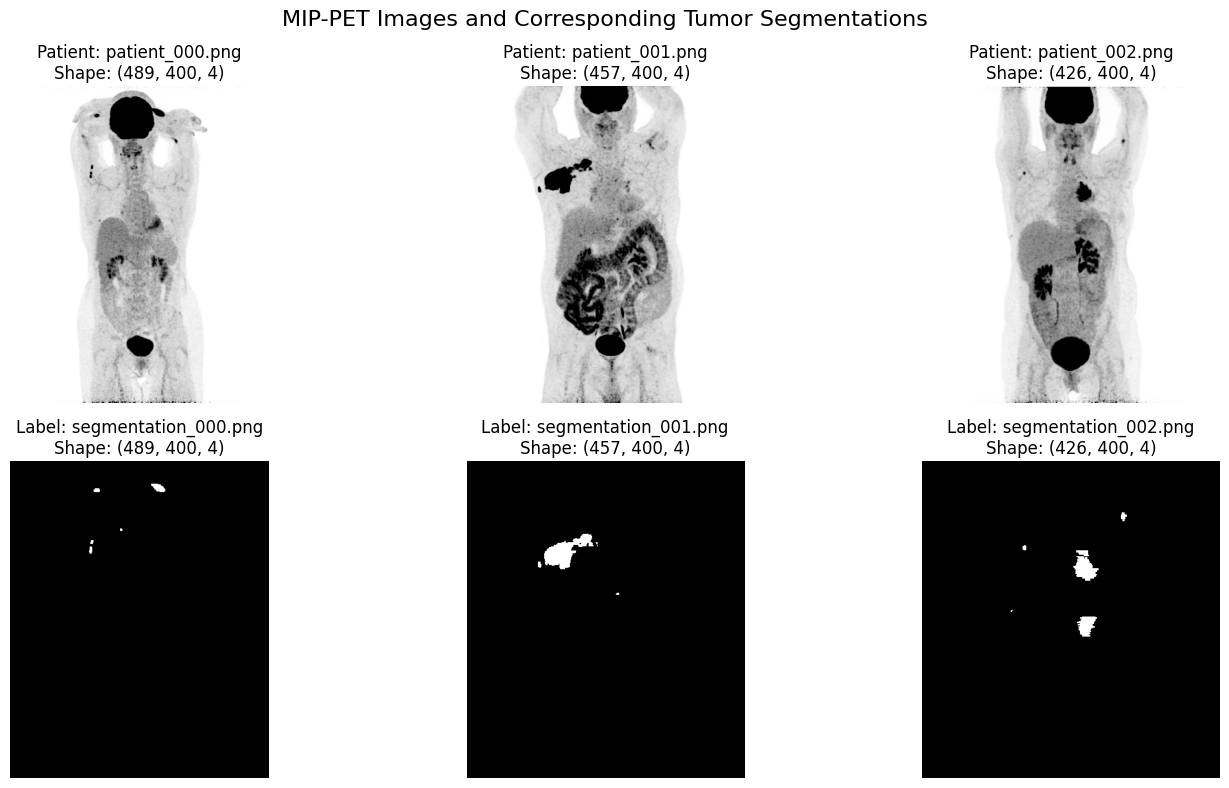

In [15]:
# Sample image visualization with correct matching
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def show_matched_samples(patients_dir, labels_dir, matching_pairs, n_samples=3):
    """Display sample images with their correctly matched labels"""
    
    if len(matching_pairs) == 0:
        print("❌ No matching pairs found!")
        return
    
    # Take first n_samples pairs
    sample_pairs = matching_pairs[:n_samples]
    
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 8))
    
    for i, (patient_file, label_file) in enumerate(sample_pairs):
        # Load patient image
        patient_path = os.path.join(patients_dir, patient_file)
        patient_img = Image.open(patient_path)
        patient_array = np.array(patient_img)
        
        # Load label image
        label_path = os.path.join(labels_dir, label_file)
        label_img = Image.open(label_path)
        label_array = np.array(label_img)
        
        # Display patient image
        axes[0, i].imshow(patient_array, cmap='gray')
        axes[0, i].set_title(f'Patient: {patient_file}\nShape: {patient_array.shape}')
        axes[0, i].axis('off')
        
        # Display label
        axes[1, i].imshow(label_array, cmap='gray')
        axes[1, i].set_title(f'Label: {label_file}\nShape: {label_array.shape}')
        axes[1, i].axis('off')
        
        # Print some stats
        tumor_pixels = np.sum(label_array > 127)
        total_pixels = label_array.size
        tumor_ratio = tumor_pixels / total_pixels
        print(f"{patient_file}: Tumor coverage = {tumor_ratio:.3f} ({tumor_ratio*100:.1f}%)")
    
    plt.suptitle('MIP-PET Images and Corresponding Tumor Segmentations', fontsize=16)
    plt.tight_layout()
    plt.show()

# Show matched samples
show_matched_samples(
    os.path.join(data_dir, 'patients', 'imgs'),
    os.path.join(data_dir, 'patients', 'labels'),
    matching_pairs
)

In [16]:
# Analyze image size distributions
def analyze_image_sizes(patients_dir, controls_dir, labels_dir):
    """Analyze the distribution of image sizes across the dataset"""
    
    print("📏 IMAGE SIZE ANALYSIS")
    print("=" * 50)
    
    # Collect size data
    all_sizes = {'patients': [], 'controls': [], 'labels': []}
    
    # Patient images
    if os.path.exists(patients_dir):
        patient_files = [f for f in os.listdir(patients_dir) if f.endswith('.png')]
        for file in patient_files:
            img = Image.open(os.path.join(patients_dir, file))
            all_sizes['patients'].append(img.size)  # (width, height)
    
    # Control images
    if os.path.exists(controls_dir):
        control_files = [f for f in os.listdir(controls_dir) if f.endswith('.png')]
        for file in control_files:
            img = Image.open(os.path.join(controls_dir, file))
            all_sizes['controls'].append(img.size)
    
    # Label images
    if os.path.exists(labels_dir):
        label_files = [f for f in os.listdir(labels_dir) if f.endswith('.png')]
        for file in label_files:
            img = Image.open(os.path.join(labels_dir, file))
            all_sizes['labels'].append(img.size)
    
    # Analyze sizes
    for category, sizes in all_sizes.items():
        if sizes:
            widths = [s[0] for s in sizes]
            heights = [s[1] for s in sizes]
            
            print(f"\n{category.upper()}:")
            print(f"  Count: {len(sizes)}")
            print(f"  Width:  min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.1f}")
            print(f"  Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.1f}")
            print(f"  Unique sizes: {len(set(sizes))}")
            
            # Most common size
            from collections import Counter
            size_counts = Counter(sizes)
            most_common = size_counts.most_common(3)
            print(f"  Most common sizes: {most_common}")
    
    # Recommend target size
    all_patient_sizes = all_sizes['patients']
    if all_patient_sizes:
        all_widths = [s[0] for s in all_patient_sizes]
        all_heights = [s[1] for s in all_patient_sizes]
        
        # Use median or most common size as target
        target_width = int(np.median(all_widths))
        target_height = int(np.median(all_heights))
        
        print(f"\n💡 RECOMMENDATION:")
        print(f"  Target size for preprocessing: {target_width} x {target_height}")
        
        return target_width, target_height
    
    return None, None

# Analyze image sizes
target_w, target_h = analyze_image_sizes(
    os.path.join(data_dir, 'patients', 'imgs'),
    os.path.join(data_dir, 'controls', 'imgs'),
    os.path.join(data_dir, 'patients', 'labels')
)

📏 IMAGE SIZE ANALYSIS

PATIENTS:
  Count: 182
  Width:  min=400, max=400, mean=400.0
  Height: min=423, max=979, mean=499.4
  Unique sizes: 37
  Most common sizes: [((400, 489), 79), ((400, 426), 58), ((400, 552), 4)]

CONTROLS:
  Count: 426
  Width:  min=400, max=400, mean=400.0
  Height: min=300, max=991, mean=515.3
  Unique sizes: 105
  Most common sizes: [((400, 489), 106), ((400, 426), 65), ((400, 363), 18)]

LABELS:
  Count: 182
  Width:  min=400, max=400, mean=400.0
  Height: min=423, max=979, mean=499.4
  Unique sizes: 37
  Most common sizes: [((400, 489), 79), ((400, 426), 58), ((400, 552), 4)]

💡 RECOMMENDATION:
  Target size for preprocessing: 400 x 489


In [17]:
# Analyze pixel intensity distributions
def analyze_pixel_intensities(patients_dir, controls_dir, sample_size=50):
    """Analyze pixel intensity distributions for normalization"""
    
    print("🎨 PIXEL INTENSITY ANALYSIS")
    print("=" * 50)
    
    # Sample images for analysis
    patient_files = [f for f in os.listdir(patients_dir) if f.endswith('.png')][:sample_size]
    control_files = [f for f in os.listdir(controls_dir) if f.endswith('.png')][:sample_size]
    
    patient_stats = {'min': [], 'max': [], 'mean': [], 'std': []}
    control_stats = {'min': [], 'max': [], 'mean': [], 'std': []}
    
    # Analyze patient images
    print("Analyzing patient images...")
    for file in patient_files:
        img = np.array(Image.open(os.path.join(patients_dir, file)))
        patient_stats['min'].append(img.min())
        patient_stats['max'].append(img.max())
        patient_stats['mean'].append(img.mean())
        patient_stats['std'].append(img.std())
    
    # Analyze control images
    print("Analyzing control images...")
    for file in control_files:
        img = np.array(Image.open(os.path.join(controls_dir, file)))
        control_stats['min'].append(img.min())
        control_stats['max'].append(img.max())
        control_stats['mean'].append(img.mean())
        control_stats['std'].append(img.std())
    
    # Print statistics
    print(f"\nPATIENT IMAGES (n={len(patient_files)}):")
    for stat, values in patient_stats.items():
        print(f"  {stat.upper()}: min={np.min(values):.1f}, max={np.max(values):.1f}, "
              f"mean={np.mean(values):.1f}, std={np.std(values):.1f}")
    
    print(f"\nCONTROL IMAGES (n={len(control_files)}):")
    for stat, values in control_stats.items():
        print(f"  {stat.upper()}: min={np.min(values):.1f}, max={np.max(values):.1f}, "
              f"mean={np.mean(values):.1f}, std={np.std(values):.1f}")
    
    # Calculate normalization parameters
    all_means = patient_stats['mean'] + control_stats['mean']
    all_stds = patient_stats['std'] + control_stats['std']
    
    dataset_mean = np.mean(all_means)
    dataset_std = np.mean(all_stds)
    
    print(f"\n💡 NORMALIZATION PARAMETERS:")
    print(f"  Dataset mean: {dataset_mean:.3f}")
    print(f"  Dataset std:  {dataset_std:.3f}")
    print(f"  Recommended normalization: (pixel - {dataset_mean:.3f}) / {dataset_std:.3f}")
    
    return dataset_mean, dataset_std

# Analyze pixel intensities
dataset_mean, dataset_std = analyze_pixel_intensities(
    os.path.join(data_dir, 'patients', 'imgs'),
    os.path.join(data_dir, 'controls', 'imgs')
)

🎨 PIXEL INTENSITY ANALYSIS
Analyzing patient images...
Analyzing control images...

PATIENT IMAGES (n=50):
  MIN: min=0.0, max=0.0, mean=0.0, std=0.0
  MAX: min=255.0, max=255.0, mean=255.0, std=0.0
  MEAN: min=212.1, max=240.9, mean=228.1, std=5.1
  STD: min=34.9, max=78.8, mean=51.7, std=6.8

CONTROL IMAGES (n=50):
  MIN: min=0.0, max=0.0, mean=0.0, std=0.0
  MAX: min=255.0, max=255.0, mean=255.0, std=0.0
  MEAN: min=223.2, max=240.6, mean=229.6, std=4.2
  STD: min=33.5, max=58.3, mean=47.9, std=5.2

💡 NORMALIZATION PARAMETERS:
  Dataset mean: 228.885
  Dataset std:  49.786
  Recommended normalization: (pixel - 228.885) / 49.786


🔧 TESTING PREPROCESSING
Original image: (489, 400, 4), dtype=uint8, range=[0, 255]
Preprocessed image: (256, 256), dtype=float32, range=[-4.597, 0.525]
Original label: (489, 400, 4), dtype=uint8, range=[0, 255]
Preprocessed label: (256, 256), dtype=float32, range=[0.0, 1.0]


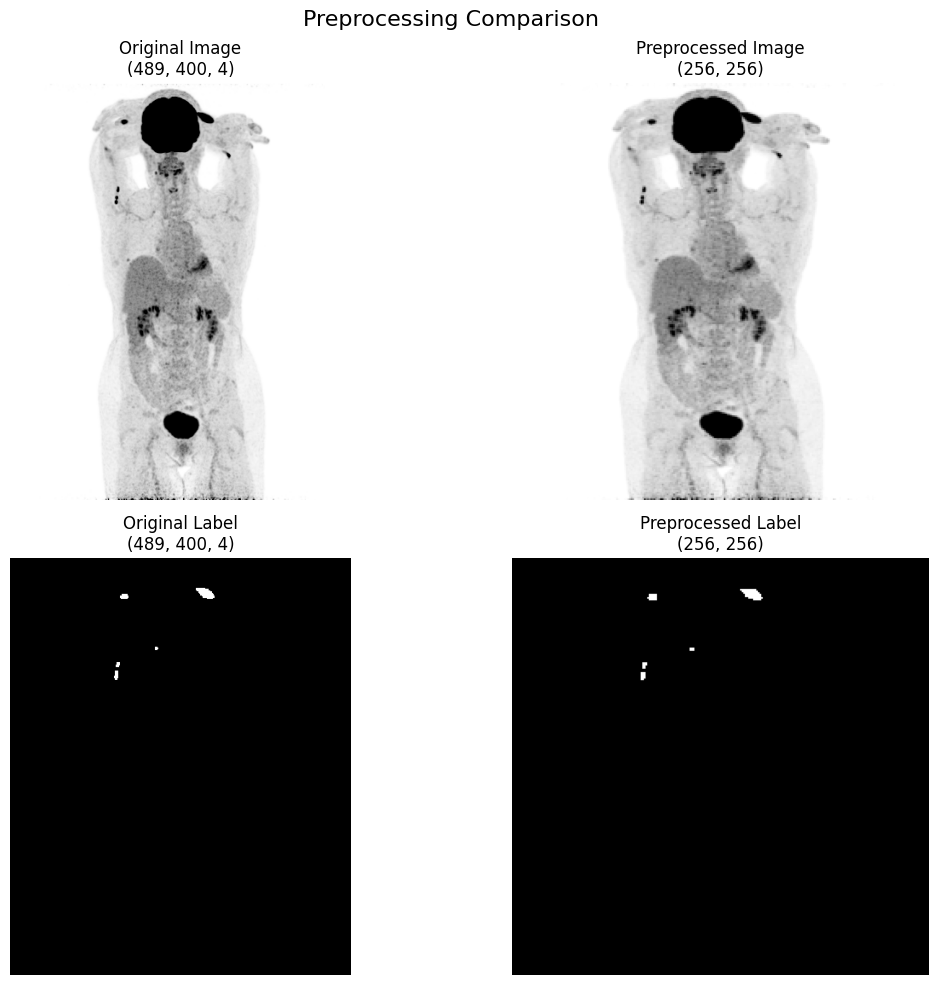

In [18]:
# Preprocessing functions
import cv2
def preprocess_image(img_path, target_size=(256, 256), normalize=True, 
                    mean=None, std=None):
    """
    Preprocess a single image: resize, normalize
    
    Args:
        img_path: Path to image file
        target_size: Target (width, height) 
        normalize: Whether to normalize pixel values
        mean, std: Normalization parameters
    
    Returns:
        Preprocessed image as numpy array
    """
    # Load image
    img = Image.open(img_path)
    img_array = np.array(img)
    
    # Handle different image formats
    if len(img_array.shape) == 3:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    
    # Resize image
    img_resized = cv2.resize(img_array, target_size, interpolation=cv2.INTER_LINEAR)
    
    # Normalize if requested
    if normalize and mean is not None and std is not None:
        img_normalized = (img_resized.astype(np.float32) - mean) / std
        return img_normalized
    else:
        return img_resized.astype(np.float32) / 255.0  # Scale to [0,1]

def preprocess_label(label_path, target_size=(256, 256)):
    """
    Preprocess a label mask: resize, binarize
    
    Args:
        label_path: Path to label file
        target_size: Target (width, height)
    
    Returns:
        Binary mask as numpy array (0 or 1)
    """
    # Load label
    label = Image.open(label_path)
    label_array = np.array(label)
    
    # Handle different formats
    if len(label_array.shape) == 3:
        label_array = cv2.cvtColor(label_array, cv2.COLOR_RGB2GRAY)
    
    # Resize label
    label_resized = cv2.resize(label_array, target_size, interpolation=cv2.INTER_NEAREST)
    
    # Binarize (tumor = 1, background = 0)
    binary_mask = (label_resized > 127).astype(np.float32)
    
    return binary_mask

# Test preprocessing on sample images
print("🔧 TESTING PREPROCESSING")
print("=" * 30)

if matching_pairs:
    # Get first matching pair
    patient_file, label_file = matching_pairs[0]
    
    patient_path = os.path.join(data_dir, 'patients', 'imgs', patient_file)
    label_path = os.path.join(data_dir, 'patients', 'labels', label_file)
    
    # Original images
    orig_img = np.array(Image.open(patient_path))
    orig_label = np.array(Image.open(label_path))
    
    # Preprocessed images
    prep_img = preprocess_image(patient_path, target_size=(256, 256), 
                               normalize=True, mean=dataset_mean, std=dataset_std)
    prep_label = preprocess_label(label_path, target_size=(256, 256))
    
    print(f"Original image: {orig_img.shape}, dtype={orig_img.dtype}, range=[{orig_img.min()}, {orig_img.max()}]")
    print(f"Preprocessed image: {prep_img.shape}, dtype={prep_img.dtype}, range=[{prep_img.min():.3f}, {prep_img.max():.3f}]")
    print(f"Original label: {orig_label.shape}, dtype={orig_label.dtype}, range=[{orig_label.min()}, {orig_label.max()}]")
    print(f"Preprocessed label: {prep_label.shape}, dtype={prep_label.dtype}, range=[{prep_label.min()}, {prep_label.max()}]")
    
    # Visualize preprocessing results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original image
    axes[0,0].imshow(orig_img, cmap='gray')
    axes[0,0].set_title(f'Original Image\n{orig_img.shape}')
    axes[0,0].axis('off')
    
    # Preprocessed image
    axes[0,1].imshow(prep_img, cmap='gray')
    axes[0,1].set_title(f'Preprocessed Image\n{prep_img.shape}')
    axes[0,1].axis('off')
    
    # Original label
    axes[1,0].imshow(orig_label, cmap='gray')
    axes[1,0].set_title(f'Original Label\n{orig_label.shape}')
    axes[1,0].axis('off')
    
    # Preprocessed label
    axes[1,1].imshow(prep_label, cmap='gray')
    axes[1,1].set_title(f'Preprocessed Label\n{prep_label.shape}')
    axes[1,1].axis('off')
    
    plt.suptitle('Preprocessing Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

else:
    print("No matching pairs found for testing!")

In [19]:
# Create preprocessed dataset function
def create_preprocessed_dataset(data_dir, output_dir, target_size=(256, 256)):
    """
    Create a preprocessed version of the entire dataset (saved as PNG)
    """
    import os
    
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'patients', 'imgs'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'patients', 'labels'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'controls', 'imgs'), exist_ok=True)
    
    print(f"Creating preprocessed dataset in {output_dir}")
    print(f"Target size: {target_size}")
    print(f"Normalization: mean={dataset_mean:.3f}, std={dataset_std:.3f}")
    
    # Process patient images and labels
    patients_imgs = os.path.join(data_dir, 'patients', 'imgs')
    patients_labels = os.path.join(data_dir, 'patients', 'labels')
    
    for patient_file, label_file in matching_pairs:
        # Process image
        img_path = os.path.join(patients_imgs, patient_file)
        prep_img = preprocess_image(img_path, target_size, True, dataset_mean, dataset_std)
        
        # Process label
        label_path = os.path.join(patients_labels, label_file)
        prep_label = preprocess_label(label_path, target_size)
        
        # Convert back to uint8 for PNG saving
        prep_img_uint8 = ((prep_img - prep_img.min()) / (prep_img.max() - prep_img.min()) * 255).astype(np.uint8)
        prep_label_uint8 = (prep_label * 255).astype(np.uint8)
        
        # Save preprocessed files as PNG
        Image.fromarray(prep_img_uint8).save(os.path.join(output_dir, 'patients', 'imgs', patient_file))
        Image.fromarray(prep_label_uint8).save(os.path.join(output_dir, 'patients', 'labels', label_file))
    
    # Process control images
    controls_imgs = os.path.join(data_dir, 'controls', 'imgs')
    control_files = [f for f in os.listdir(controls_imgs) if f.endswith('.png')]
    
    for control_file in control_files:
        img_path = os.path.join(controls_imgs, control_file)
        prep_img = preprocess_image(img_path, target_size, True, dataset_mean, dataset_std)
        
        # Convert back to uint8 for PNG saving
        prep_img_uint8 = ((prep_img - prep_img.min()) / (prep_img.max() - prep_img.min()) * 255).astype(np.uint8)
        
        # Save preprocessed file as PNG
        Image.fromarray(prep_img_uint8).save(os.path.join(output_dir, 'controls', 'imgs', control_file))
    
    print(f"✅ Preprocessed dataset created as PNG files!")
    print(f"   Patient images: {len(matching_pairs)}")
    print(f"   Patient labels: {len(matching_pairs)}")
    print(f"   Control images: {len(control_files)}")


🎨 VISUALIZING AUGMENTATIONS


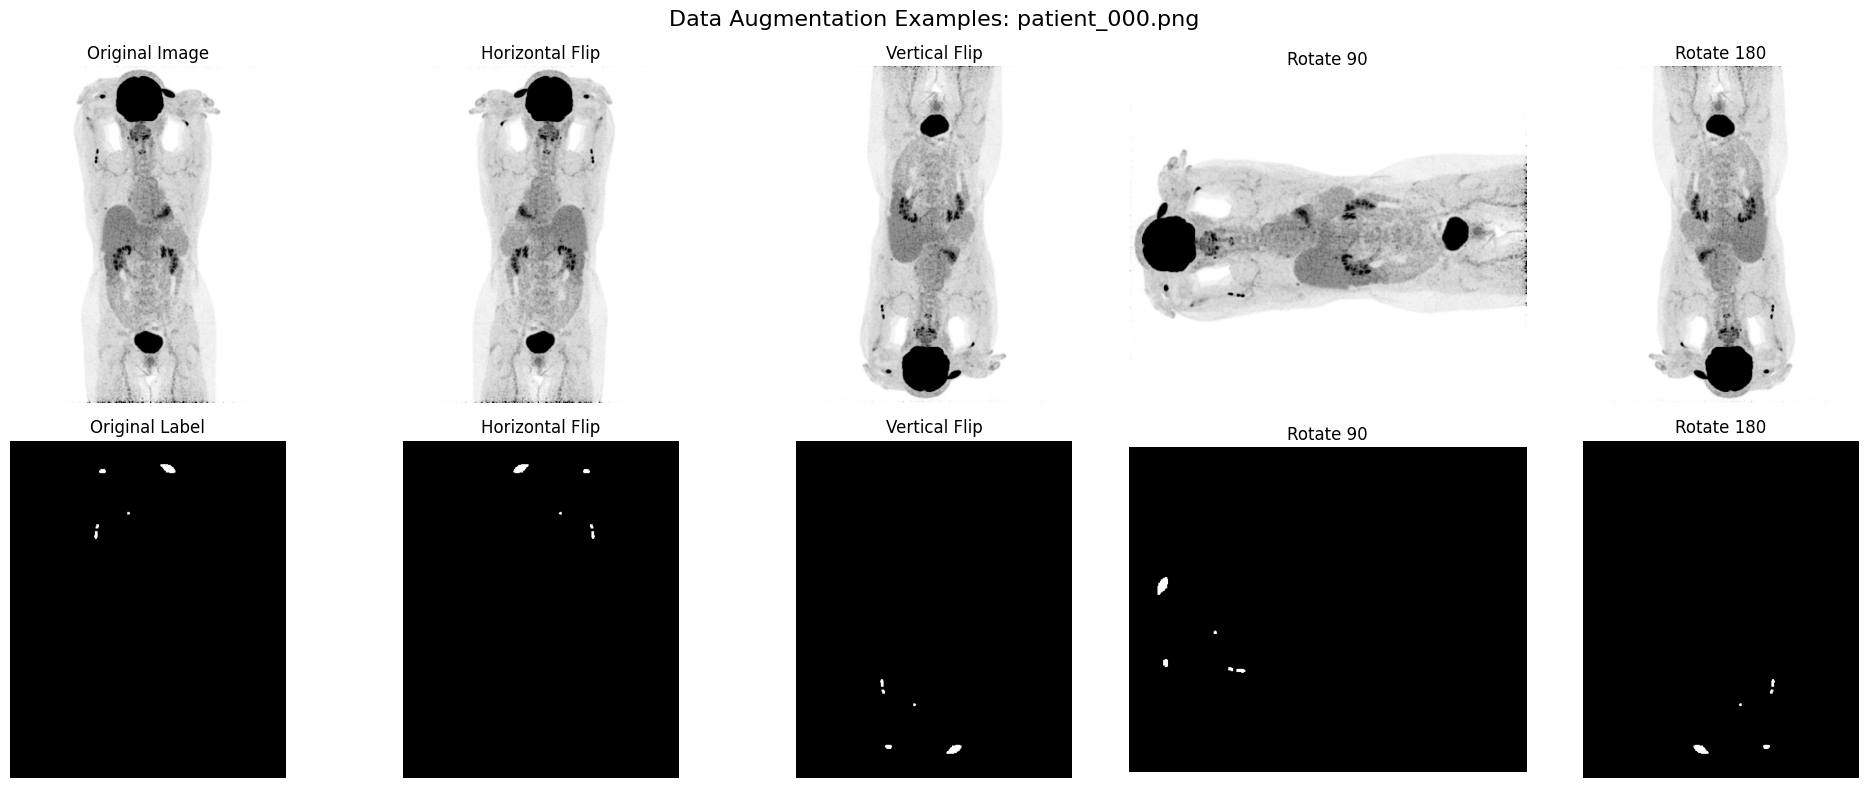

In [20]:
# Data Augmentation Functions
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def augment_image_and_label(img_array, label_array, augmentation_type):
    """
    Apply the same augmentation to both image and label
    
    Args:
        img_array: Input image as numpy array
        label_array: Input label as numpy array  
        augmentation_type: Type of augmentation to apply
    
    Returns:
        Augmented image and label arrays
    """
    
    if augmentation_type == 'horizontal_flip':
        aug_img = np.fliplr(img_array)
        aug_label = np.fliplr(label_array)
        
    elif augmentation_type == 'vertical_flip':
        aug_img = np.flipud(img_array)
        aug_label = np.flipud(label_array)
        
    elif augmentation_type == 'rotate_90':
        aug_img = np.rot90(img_array)
        aug_label = np.rot90(label_array)
        
    elif augmentation_type == 'rotate_180':
        aug_img = np.rot90(img_array, 2)
        aug_label = np.rot90(label_array, 2)
        
    else:
        # No augmentation
        aug_img = img_array
        aug_label = label_array
    
    return aug_img, aug_label

def create_augmented_dataset(data_dir, output_dir, target_size=(256, 256), 
                           augmentations=['horizontal_flip', 'vertical_flip', 'rotate_90', 'rotate_180']):
    """
    Create an augmented dataset with multiple versions of each tumor case (saved as PNG)
    """
    import os
    from tqdm import tqdm
    
    print("🔄 CREATING AUGMENTED DATASET")
    print("=" * 50)
    print(f"Augmentations to apply: {augmentations}")
    print(f"Expected increase in tumor cases: {len(augmentations)}x")
    print(f"Output format: PNG files")
    
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'patients', 'imgs'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'patients', 'labels'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'controls', 'imgs'), exist_ok=True)
    
    patients_imgs = os.path.join(data_dir, 'patients', 'imgs')
    patients_labels = os.path.join(data_dir, 'patients', 'labels')
    controls_imgs = os.path.join(data_dir, 'controls', 'imgs')
    
    # Process patient images and labels with augmentation
    print("\n🏥 Processing patient images with augmentation...")
    augmented_count = 0
    
    for patient_file, label_file in tqdm(matching_pairs, desc="Augmenting patients"):
        # Load original images
        img_path = os.path.join(patients_imgs, patient_file)
        label_path = os.path.join(patients_labels, label_file)
        
        img = np.array(Image.open(img_path))
        label = np.array(Image.open(label_path))
        
        # Save original (preprocessed)
        prep_img = preprocess_image(img_path, target_size, True, dataset_mean, dataset_std)
        prep_label = preprocess_label(label_path, target_size)
        
        base_name = patient_file.replace('.png', '')
        label_base_name = label_file.replace('.png', '')
        
        # Convert to uint8 for PNG saving
        prep_img_uint8 = ((prep_img - prep_img.min()) / (prep_img.max() - prep_img.min()) * 255).astype(np.uint8)
        prep_label_uint8 = (prep_label * 255).astype(np.uint8)
        
        # Save as PNG
        Image.fromarray(prep_img_uint8).save(os.path.join(output_dir, 'patients', 'imgs', f'{base_name}_original.png'))
        Image.fromarray(prep_label_uint8).save(os.path.join(output_dir, 'patients', 'labels', f'{label_base_name}_original.png'))
        
        # Create augmented versions
        for aug_type in augmentations:
            aug_img, aug_label = augment_image_and_label(img, label, aug_type)
            
            # Preprocess augmented versions
            # Save to temporary files first
            temp_img_path = f'/tmp/temp_aug_img.png'
            temp_label_path = f'/tmp/temp_aug_label.png'
            
            Image.fromarray(aug_img).save(temp_img_path)
            Image.fromarray(aug_label).save(temp_label_path)
            
            prep_aug_img = preprocess_image(temp_img_path, target_size, True, dataset_mean, dataset_std)
            prep_aug_label = preprocess_label(temp_label_path, target_size)
            
            # Convert to uint8 for PNG saving
            prep_aug_img_uint8 = ((prep_aug_img - prep_aug_img.min()) / (prep_aug_img.max() - prep_aug_img.min()) * 255).astype(np.uint8)
            prep_aug_label_uint8 = (prep_aug_label * 255).astype(np.uint8)
            
            # Save augmented versions as PNG
            Image.fromarray(prep_aug_img_uint8).save(os.path.join(output_dir, 'patients', 'imgs', f'{base_name}_{aug_type}.png'))
            Image.fromarray(prep_aug_label_uint8).save(os.path.join(output_dir, 'patients', 'labels', f'{label_base_name}_{aug_type}.png'))
            
            augmented_count += 1
    
    # Process control images (minimal augmentation to avoid overfitting on controls)
    print("\n🏥 Processing control images...")
    control_files = [f for f in os.listdir(controls_imgs) if f.endswith('.png')]
    
    for control_file in tqdm(control_files, desc="Processing controls"):
        img_path = os.path.join(controls_imgs, control_file)
        prep_img = preprocess_image(img_path, target_size, True, dataset_mean, dataset_std)
        
        # Convert to uint8 for PNG saving
        prep_img_uint8 = ((prep_img - prep_img.min()) / (prep_img.max() - prep_img.min()) * 255).astype(np.uint8)
        
        # Save as PNG
        Image.fromarray(prep_img_uint8).save(os.path.join(output_dir, 'controls', 'imgs', control_file))
    
    print(f"\n✅ AUGMENTED DATASET CREATED (PNG FORMAT)!")
    print(f"   Original patient images: {len(matching_pairs)}")
    print(f"   Augmented patient images: {augmented_count}")
    print(f"   Total patient images: {len(matching_pairs) + augmented_count}")
    print(f"   Control images: {len(control_files)}")
    print(f"   Augmentation factor: {(len(matching_pairs) + augmented_count) / len(matching_pairs):.1f}x")
    print(f"   All files saved as PNG!")

# Test augmentation on a sample
def visualize_augmentations(patient_file, label_file, augmentations=['horizontal_flip', 'rotate_90']):
    """Visualize different augmentations applied to a sample"""
    
    patients_imgs = os.path.join(data_dir, 'patients', 'imgs')
    patients_labels = os.path.join(data_dir, 'patients', 'labels')
    
    # Load original
    img_path = os.path.join(patients_imgs, patient_file)
    label_path = os.path.join(patients_labels, label_file)
    
    orig_img = np.array(Image.open(img_path))
    orig_label = np.array(Image.open(label_path))
    
    # Create figure
    n_augs = len(augmentations) + 1  # +1 for original
    fig, axes = plt.subplots(2, n_augs, figsize=(4*n_augs, 8))
    
    # Show original
    axes[0, 0].imshow(orig_img, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(orig_label, cmap='gray')
    axes[1, 0].set_title('Original Label')
    axes[1, 0].axis('off')
    
    # Show augmentations
    for i, aug_type in enumerate(augmentations):
        aug_img, aug_label = augment_image_and_label(orig_img, orig_label, aug_type)
        
        axes[0, i+1].imshow(aug_img, cmap='gray')
        axes[0, i+1].set_title(f'{aug_type.replace("_", " ").title()}')
        axes[0, i+1].axis('off')
        
        axes[1, i+1].imshow(aug_label, cmap='gray')
        axes[1, i+1].set_title(f'{aug_type.replace("_", " ").title()}')
        axes[1, i+1].axis('off')
    
    plt.suptitle(f'Data Augmentation Examples: {patient_file}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize augmentations on first sample
if matching_pairs:
    print("🎨 VISUALIZING AUGMENTATIONS")
    print("=" * 40)
    patient_file, label_file = matching_pairs[0]
    visualize_augmentations(patient_file, label_file, 
                          ['horizontal_flip', 'vertical_flip', 'rotate_90', 'rotate_180'])


In [21]:
# Analyze augmentation impact
def analyze_augmentation_impact(augmentations=['horizontal_flip', 'vertical_flip', 'rotate_90', 'rotate_180']):
    """Analyze how augmentation affects dataset balance"""
    
    print("📈 AUGMENTATION IMPACT ANALYSIS")
    print("=" * 50)
    
    # Original dataset
    original_patients = len(matching_pairs)
    original_controls = len([f for f in os.listdir(os.path.join(data_dir, 'controls', 'imgs')) if f.endswith('.png')])
    original_total = original_patients + original_controls
    
    # After augmentation
    augmented_patients = original_patients * (len(augmentations) + 1)  # +1 for original
    augmented_total = augmented_patients + original_controls
    
    print("BEFORE AUGMENTATION:")
    print(f"  Patient images (with tumors): {original_patients} ({original_patients/original_total*100:.1f}%)")
    print(f"  Control images (no tumors):   {original_controls} ({original_controls/original_total*100:.1f}%)")
    print(f"  Total images:                 {original_total}")
    print(f"  Class imbalance ratio:        1:{original_controls/original_patients:.1f}")
    
    print("\nAFTER AUGMENTATION:")
    print(f"  Patient images (with tumors): {augmented_patients} ({augmented_patients/augmented_total*100:.1f}%)")
    print(f"  Control images (no tumors):   {original_controls} ({original_controls/augmented_total*100:.1f}%)")
    print(f"  Total images:                 {augmented_total}")
    print(f"  Class imbalance ratio:        1:{original_controls/augmented_patients:.1f}")
    
    print(f"\nIMPROVEMENT:")
    print(f"  Tumor examples increased by:  {len(augmentations)}x")
    print(f"  Class balance improved by:    {(original_controls/original_patients) / (original_controls/augmented_patients):.1f}x")
    
    return augmented_patients, original_controls

# Analyze impact
analyze_augmentation_impact()

📈 AUGMENTATION IMPACT ANALYSIS
BEFORE AUGMENTATION:
  Patient images (with tumors): 182 (29.9%)
  Control images (no tumors):   426 (70.1%)
  Total images:                 608
  Class imbalance ratio:        1:2.3

AFTER AUGMENTATION:
  Patient images (with tumors): 910 (68.1%)
  Control images (no tumors):   426 (31.9%)
  Total images:                 1336
  Class imbalance ratio:        1:0.5

IMPROVEMENT:
  Tumor examples increased by:  4x
  Class balance improved by:    5.0x


(910, 426)

In [22]:
# Call function to create augmented dataset
create_augmented_dataset(data_dir, './augmented_data', target_size=(256, 256))

🔄 CREATING AUGMENTED DATASET
Augmentations to apply: ['horizontal_flip', 'vertical_flip', 'rotate_90', 'rotate_180']
Expected increase in tumor cases: 4x
Output format: PNG files

🏥 Processing patient images with augmentation...


Augmenting patients: 100%|████████████████████| 182/182 [01:00<00:00,  3.03it/s]



🏥 Processing control images...


Processing controls: 100%|████████████████████| 426/426 [00:12<00:00, 34.12it/s]


✅ AUGMENTED DATASET CREATED (PNG FORMAT)!
   Original patient images: 182
   Augmented patient images: 728
   Total patient images: 910
   Control images: 426
   Augmentation factor: 5.0x
   All files saved as PNG!
